<a href="https://colab.research.google.com/github/oscarjose9423/Modelling/blob/main/Modelado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h1> Modelado  </h1>

Este documento hace parte de la presentación de los modelos empleados para el desarrollo del proyecto de innovación agrícola y pecuaria. Se plantean la metodología empleada para el desarrollo de 2 de los diferentes modelos, uno de regresión sigmoidal y otro de clasificación no supervisada por mediante la metodología k-cluster.

<p><a name="contents"></a></p>

# Contenido 

- <a href="#colabIntro">1.  Modelo de producción acumulada sigmoide o ogarítmica </a><br>
- <a href="#pythonIntro">2. Modelo de clasificación para especies de ovejo</a><br>


<p><a name="colabIntro"></a></p>

# 1)  Modelo de producción acumulada sigmoide o logarítmica

El modelo de producción acumulada para la especie de la yuca, permitió a los campesinos de la región del piedemonte amazónico obtener un estimado de su producción para ciclo productivo total de la especie. Las condiciones fueron área especifica para el caso de la investigación 0,5 ha, empleo de prácticas anscetrales y un selecto grupo de tratamientos bioquimicos ajutados a los requerimientos edáficos.


# 1.1)  Función sigmoide

La función sigmoide tiene ajustes y puntajes bastante aceptables para series de tiempo en este caso una producción acumulada diaria para todos los meses de producción del tuberculo. Es importante indicar que se evaluaron maquinas de soporte vectorial regresoras con función de base radial, de las cuales se estimó como mejor modelo la función sigmoide:

$$ Y = a + \frac{b}{1+ c^{(X-d)}}$$

de esta función se obtiene:


$$ \hat{Y} = \frac1{1+e^{\beta_1(X-\beta_2)}}$$

Tenemos que

$\beta_1$: contrala la inclinación de la curva,

$\beta_2$: proyecta la curva en x.

estos dos ultimos valores son denominados hiperparámetros de la función cuyo valor esta sujeto a cambios en los que se pueda obtener mediante metodologías de busqueda de paramétros que para este caso se empleo el método __curve_fit__ `scipy`, que usa un ajuste de mínimos cuadrados no lineal para ajustar nuesta función sigmoide a los datos. 

El algoritmo ajusta iterativamente los parámetros, de tal forma que la suma de los residuos cuadrados $sig(x_{data}, *popt) - y_{data}$ se minimiza.

A continuación inician los procedimientos empleados concernientes a limpieza, llenado de datos, ajuste, modelo y análisis gráfico

* La limpieza de datos representa uno de los pasos esenciales en el desarrollo de modelos, ya que al contar con datos faltantes o elementos extraños los algortimos para la convergencia del modelo no trabajarán correctamente

In [ ]:
from google.colab import files
import pandas as pd
import io

uploaded = files.upload()

* Lectura de archivos 


In [ ]:
agricola = pd.read_csv(io.StringIO(uploaded['Consolidado agrícola exp. a feb 2020.xlsx - Hoja1.csv'].decode('utf-8')))
print(agricola.sample(10))

* Importación de librerias necesarias para el desarrollo de modelos de aprendizaje automático:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix

from scipy import stats
from scipy.stats import skewtest, levene # NO FUNCIONA SI SE TIENE NA
from sklearn.datasets import load_iris # grafica de violines
from sklearn.impute import SimpleImputer# imputador para relleno de NaN
from sklearn.model_selection import train_test_split # uso de datos de entranmiento
from sklearn.model_selection import StratifiedShuffleSplit # division de datos de entranmiento cuando no se tiene relación entre los indices para x & y
from sklearn.preprocessing import OrdinalEncoder # codificación de variables categóricas multiclase
from sklearn.preprocessing import OneHotEncoder # codificación de variables categoricas binarias
from sklearn.preprocessing import MinMaxScaler # escalado de caracteristicas o normalización
from sklearn.preprocessing import StandardScaler # estandarización
from sklearn.preprocessing import PolynomialFeatures # para hacer conversion de variable regresora
                                                     # a exponencial, segun grado de polinomio
from sklearn.linear_model import ElasticNet # redes elastícas combinanción de ridge & laso
                                            # doble penalizaición de los pesos
from sklearn.pipeline import Pipeline # 

''' ############ lIBRERIAS MODELADO ###############'''
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
''' ##### VALIDACION CRUZADA ######'''
from sklearn.model_selection import cross_val_score

from sklearn import metrics #METRICAS MSE RMSE MAE R2
import statsmodels.api as sm
from statsmodels.formula.api import ols # ORDINAL LINE SQUARE

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [ ]:
agricola = agricola.sort_values(by = 'FECHA')
agricola.set_index('FECHA', inplace = True)
agricola.reset_index(inplace = True)

* Se imprimen los tipos de variables para validar su correspodencia

In [ ]:
print(agricola.dtypes)

# CONVERSION A TIPO FECHA
agricola.FECHA = pd.to_datetime(agricola.FECHA)

# CONVERSION TIPO FLOTANTE KG
for i in range(len(agricola.KG)):
    agricola.KG[i] = agricola.KG[i].replace(",", "")
agricola.KG = agricola.KG.astype('float')

# VERIFIACIÓN
print(agricola.dtypes)

* Se validan los datos nulos y Not a Number (NaN)

In [ ]:
print(agricola.isnull().sum())
print('-'*23)
print(agricola.isna().sum())

* Datos para la elaboración del modelo

In [ ]:
yuca = yuca.groupby('FECHA', as_index = False).KG.mean()

yuca['ACUMULADO'] = yuca.KG.cumsum()

yuca['TIEMPO'] = [i.timestamp() for i in yuca.FECHA]


x_data, y_data = (yuca["TIEMPO"].values, yuca["ACUMULADO"].values)


*  Gráfica

El análisis gráfico representa elementos valiosos, ya que se pueden dar pistas del tipo de modelo a emplear, que para este caso ya esta definido a la función logaritmica/sigmoide

In [ ]:
plt.scatter('TIEMPO', 'ACUMULADO', data = yuca)
plt.show()

* Normalización

In [ ]:
# normalicemos los datos
xdata =x_data/max(x_data)
ydata =y_data/max(y_data)

* Modelo

In [ ]:
from scipy.optimize import curve_fit

# construcción del modelo, función sigmoide
def sigmoid(x, Beta_1, Beta_2):
     y = 1 / (1 + np.exp(-Beta_1*(x-Beta_2)))
     return y

In [ ]:
popt, pcov = curve_fit(sigmoid, xdata, ydata) # popt: parametros, pcov: covarianza
#imprimamos los parámetros
print(" beta_1 = %f, beta_2 = %f" % (popt[0], popt[1])) 

# Visualización del modelo
x = np.linspace(1527510400.0, 1581292800.0, 259200)
x = x/max(x)
plt.figure(figsize=(8,5))
y = sigmoid(x, popt[0], popt[1]) # modficados manualmente
plt.plot(xdata, ydata, 'ro', label='Datos')
plt.plot(x,y, linewidth=3.0, label='Ajuste')
plt.legend(loc='best')
plt.ylabel('Producción Acumulada')
plt.xlabel('Tiempo')
plt.show()

<p><a name="pythonIntro"></a></p>

# 2) Modelo de clasificación para especies de ovejo

[[Contenidos]](#contents)

El modelo fue logrado mediante el análisis de crecimiento y medición de variables de longitud y altura y la metodología de clustering para clasificación no supervisada, agrupación y posteriormente validación de especies en campo

In [ ]:
from google.colab import files
import pandas as pd
import io

uploaded = files.upload()

Saving ovejos.csv to ovejos (2).csv


In [ ]:
ovejos = pd.read_csv(io.StringIO(uploaded['ovejos.csv'].decode('utf-8')))
print(ovejos.sample(10))

          FECHA             PARTICIPANTE  MUESTREO  ...  PESO ALTURA LONGITUD
45   16/12/2019       CARLOS IVAN MOTOYA         2  ...  24.0   55.0     45.0
89   01/12/2019  JOSE ALEJANDRO BURITICA         1  ...  15.0   48.0     36.0
63   01/12/2019            JAIME MAVESOY         1  ...  11.0   46.0     35.0
80   01/12/2019  JOSE ALEJANDRO BURITICA         1  ...  20.0   55.0     44.0
142  01/12/2019   LIUS EDUARDO BENAVIDEZ         1  ...  20.0   60.0     62.0
141  01/12/2019   LIUS EDUARDO BENAVIDEZ         1  ...  27.0   58.0     60.0
147  16/12/2019   LIUS EDUARDO BENAVIDEZ         2  ...  17.0   55.0     55.0
116  01/12/2019         CLOROMIRO CORTEZ         1  ...  22.0   56.0     55.0
119  16/12/2019         CLOROMIRO CORTEZ         2  ...  23.0   57.0     54.0
134  01/12/2019   LIUS EDUARDO BENAVIDEZ         1  ...  16.0   55.0     55.0

[10 rows x 9 columns]


In [ ]:
#VERIFICACIÓN DE TIPOS

ovejos.dtypes 

[i > 1 for i in ovejos.isna().sum()]

ovejos[ovejos.PESO.isna()].PESO

#USO DE TRANSFORM PARA TENER DATASET DE LA MISMA LONGITUD DEL ORIGINAL

ovejos.groupby('FECHA').PESO.mean()

PromPesoOvejos = ovejos.PESO.mean()
PromAltOvejos = ovejos.ALTURA.mean()
PromLongOvejos = ovejos.LONGITUD.mean()

ovejos.PESO.replace(np.nan ,PromPesoOvejos , inplace = True)
ovejos.LONGITUD.replace(np.nan ,PromAltOvejos , inplace = True)
ovejos.ALTURA.replace(np.nan ,PromLongOvejos , inplace = True)

ovejos.sort_values('FECHA')
ovejos.set_index('FECHA', inplace = True)

ovejos.groupby('PARTICIPANTE')['PESO','LONGITUD','ALTURA'].aggregate(['mean'])


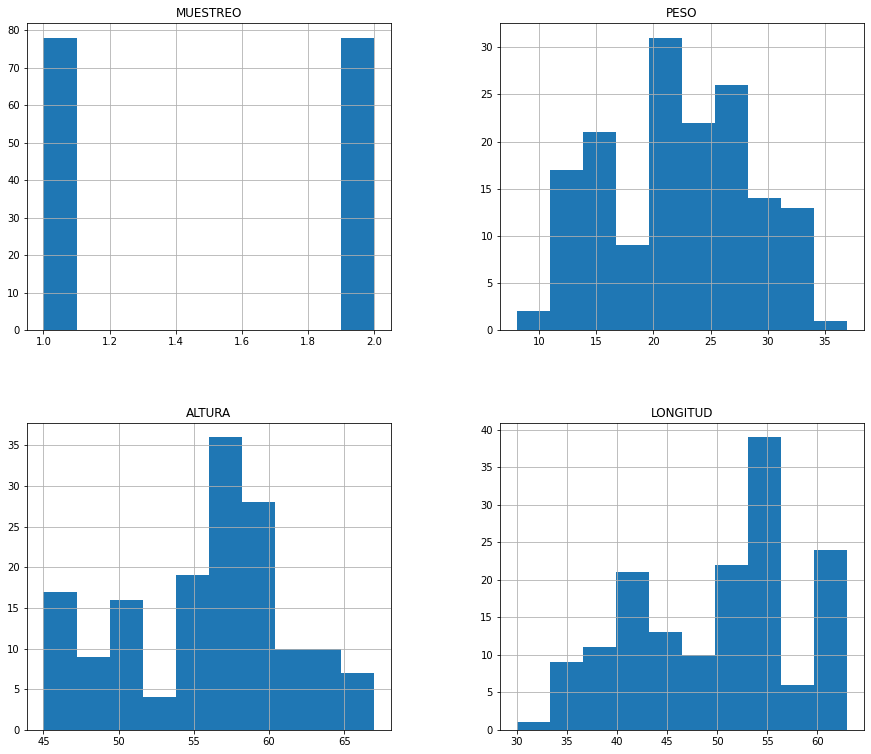

SkewtestResult(statistic=-0.40162061073175626, pvalue=0.6879632590216905)
SkewtestResult(statistic=-1.1511617640436778, pvalue=0.2496656921789402)
LeveneResult(statistic=4.354248458660251, pvalue=0.03773357588431784)


In [ ]:
'''corralaciones de pearson con scipy'''

ovejos.hist(figsize = (15,13))
plt.show()

print(skewtest(ovejos['PESO']))
print(skewtest(ovejos['ALTURA']))

print(levene(ovejos['PESO'], ovejos['ALTURA']))


In [ ]:

'''correlaciones con pandas'''

#pearson
corr_p_ovejos =ovejos.corr()
#kendall
corr_k_ovejos = ovejos.corr(method = 'kendall')
#spearman
corr_s_ovejos = ovejos.corr(method = 'spearman')

print(corr_p_ovejos)
print('-'*80)
print(corr_k_ovejos)
print('-'*80)
print(corr_s_ovejos)

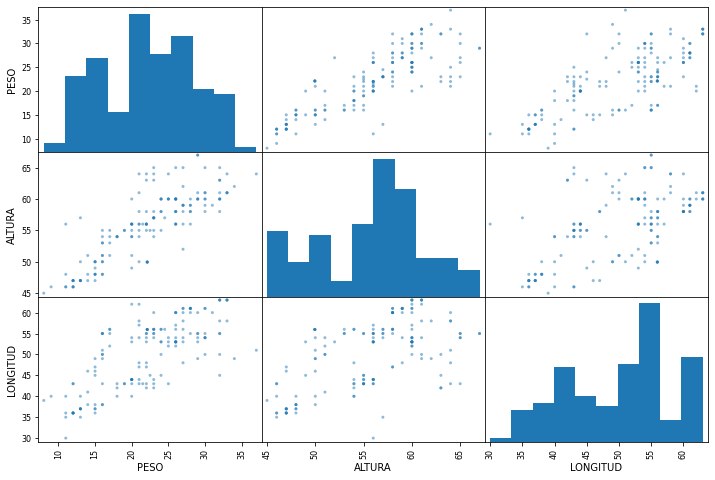

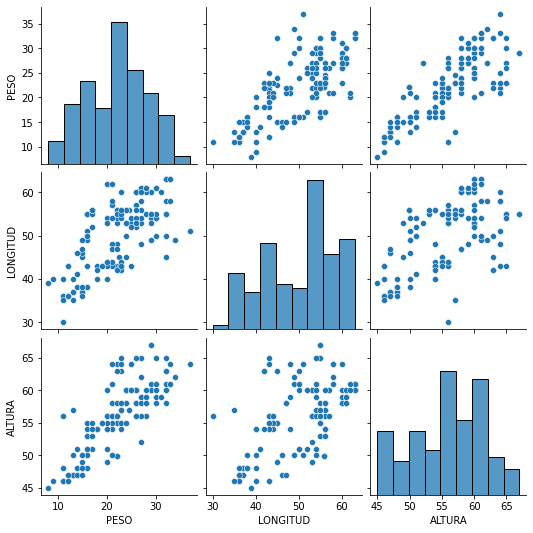

In [ ]:
'''## 3.2 ## Pair Plots, para identificar correlaciones '''

'''SCATTER MATRIX PANDAS, para identificar todos contra todos'''

from pandas.plotting import scatter_matrix

scatter_matrix(ovejos[['PESO', 'ALTURA', 'LONGITUD']], figsize = (12,8))

'''PAIR PLOT SEABORN'''

sns.pairplot(ovejos, vars = ['PESO', 'LONGITUD', 'ALTURA'])


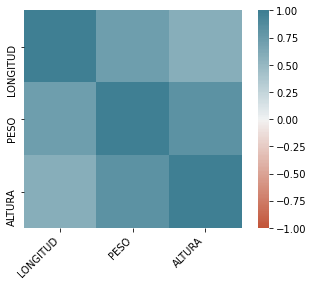

In [ ]:
''' MAPA DE CALOR '''
corr_new = ovejos[['LONGITUD','PESO','ALTURA']].corr()
ax = sns.heatmap(
    corr_new, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

* Clasificación y agrupación

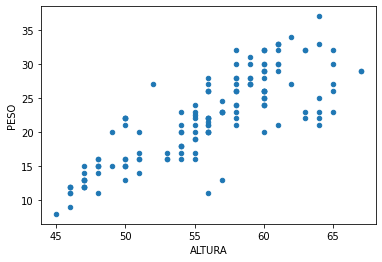

In [ ]:
ovejos.groupby('FECHA').mean()

ovejos.plot(kind="scatter", x = 'ALTURA', y = "PESO")
plt.show()